In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from caps_cropped_model import CapsuleNetwork, CapsuleLoss, display_images
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [2]:
BASE_DIR_TRAIN = "D:/Datasets/YOLO_Caps/train"
BASE_DIR_VAL = "D:/Datasets/YOLO_Caps/val"
BASE_DIR_TEST = "D:/Datasets/YOLO_Caps/test"
seed = 41
batch_size = 16
classes = ["cropped_nodule", "cropped_non_nodule"]
train_ratio = 0.8
image_size = 128
scenario = 1
data_augmentation = True

In [3]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

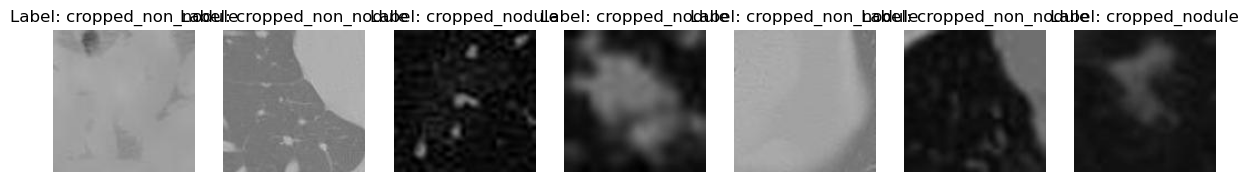

In [4]:
train_transforms = None

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                        scale=(0.8, 1.2),  # Scale for zoom in/out
                        ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform

train_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TRAIN, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TRAIN, "cropped_nodule"))), classes=classes, scenario=scenario)
val_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_VAL, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_VAL, "cropped_nodule"))), classes=classes, scenario=scenario)
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "cropped_nodule"))), classes=classes, scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
train_dataset.visualize_images(num_images=7)

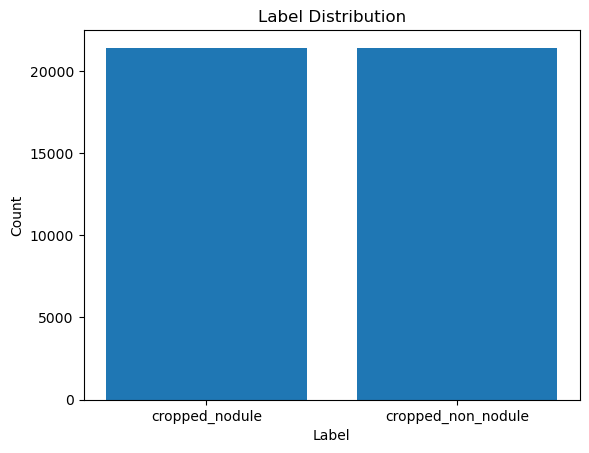

In [5]:
train_dataset.display_label_distribution()

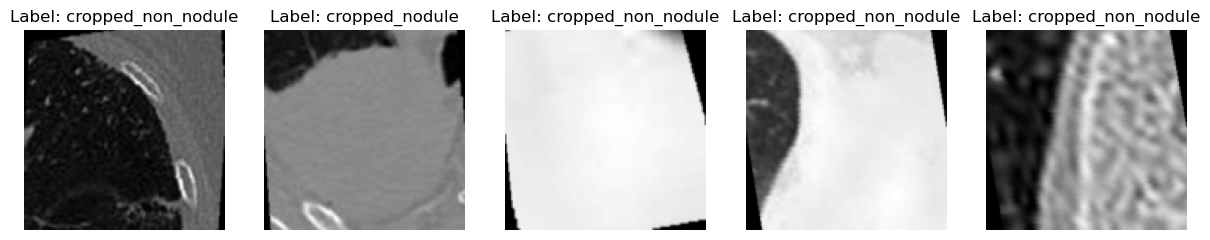

In [6]:
# train_size = int(train_ratio * len(dataset))
# testval_size = len(dataset) - train_size
# test_size = int(testval_size*0.5)
# val_size = int(testval_size*0.5)

# print(f"Train size: {train_size} --- Test size: {test_size} --- Val size: {val_size}")
# train_dataset, testval_dataset = random_split(dataset, [train_size, testval_size])
# test_dataset, val_dataset = random_split(testval_dataset, [test_size, val_size])

train_dataset = TransformDataset(train_dataset, transform=train_transforms)
val_dataset = TransformDataset(val_dataset, transform=train_transforms)
test_dataset = TransformDataset(test_dataset, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.0001)

In [9]:
n_epochs = 100
train_losses, val_losses = capsule_net.train_model(train_loader, val_loader, criterion, optimizer, n_epochs, early_stopping, print_every=1)

Epoch 1/100 ----- Loss: 3.0664, Accuracy: 83.91% ----- Validation Loss: 0.1821, Validation Accuracy: 88.65%
New best model saved
Epoch 2/100 ----- Loss: 2.9540, Accuracy: 89.95% ----- Validation Loss: 0.1808, Validation Accuracy: 89.90%
New best model saved
Epoch 3/100 ----- Loss: 2.9464, Accuracy: 90.42% ----- Validation Loss: 0.1801, Validation Accuracy: 90.64%
New best model saved
Epoch 4/100 ----- Loss: 2.9404, Accuracy: 90.96% ----- Validation Loss: 0.1792, Validation Accuracy: 91.43%
New best model saved
Epoch 5/100 ----- Loss: 2.9350, Accuracy: 91.33% ----- Validation Loss: 0.1797, Validation Accuracy: 91.21%
Epoch 6/100 ----- Loss: 2.9329, Accuracy: 91.60% ----- Validation Loss: 0.1795, Validation Accuracy: 91.64%
Epoch 7/100 ----- Loss: 2.9276, Accuracy: 91.90% ----- Validation Loss: 0.1786, Validation Accuracy: 92.54%
New best model saved
Epoch 8/100 ----- Loss: 2.9268, Accuracy: 92.08% ----- Validation Loss: 0.1786, Validation Accuracy: 92.50%
Epoch 9/100 ----- Loss: 2.9211,

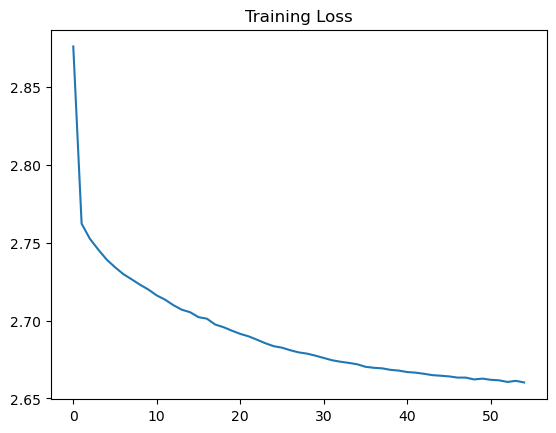

In [10]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

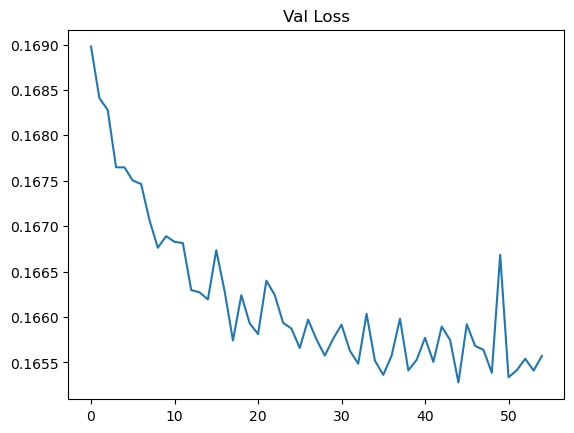

In [11]:
plt.plot(val_losses)
plt.title("Val Loss")
plt.show()

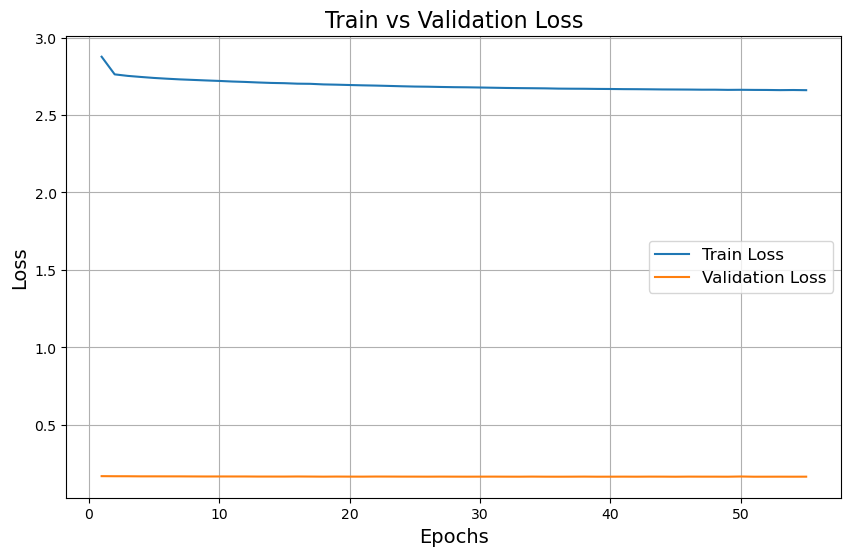

In [12]:
import matplotlib.pyplot as plt

# Annahme: train_losses und val_losses sind Listen, die die Verlustwerte enthalten
# Überprüfe, ob beide Listen die gleiche Länge haben
assert len(train_losses) == len(val_losses), "Train und Validation Losses haben unterschiedliche Längen!"

# Erstelle die Epoche-Liste (x-Achse)
epochs = range(1, len(train_losses) + 1)

# Plotten
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Titel und Achsenbeschriftung
plt.title('Train vs Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legende und Gitter
plt.legend(fontsize=12)
plt.grid(True)

# Plot anzeigen
plt.show()